In [1]:
import csv
import pandas as pd
import requests
import os
from collections import defaultdict
from datetime import timedelta
import sklearn.linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas
import matplotlib
from matplotlib.lines import Line2D

/home/gautam/.local/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
wm = geopandas.read_file("zip://../dataset/WaterMains.zip")

In [3]:
mst = geopandas.read_file("zip://../dataset/Hi.zip")

In [4]:
df=wm[["geometry","Material","InstallYea"]].copy()
df=df[df["Material"]!="CIPP"]
df=df[df["Material"]!="COPPER"]
df=df[df["Material"]!="HDPE"]
df=df[df["Material"]!="PVC"]
df["index"]=df.index
df=df[df["InstallYea"]>1800.0]

In [5]:
m = geopandas.sjoin(mst, df, how="inner", op='intersects')
m=m[["geometry","Material","InstallYea"]].copy()
m["index"]=m.index
m=m.sort_values(['index','InstallYea'])

/home/gautam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: PROJCS["NAD_1983_HARN_WISCRS_Dane_County_Feet",GEO ...

  """Entry point for launching an IPython kernel.


In [6]:
df=m.groupby(by=['index']).agg({'InstallYea': 'mean','geometry':'first','Material':'last'}).reset_index()
df=geopandas.GeoDataFrame(df)

In [7]:
df["color"]="Black"

In [8]:
matplotlib.rcParams.update({'font.size': 16})

In [9]:
year_list = [1990, 2000, 2010, 2020]
def plot(ax,year):
    if year==1990:
        ax.set_title("<"+str(year))
        df[df["InstallYea"]<year].plot(column="Material",categorical=True,legend=True,legend_kwds={'bbox_to_anchor':(.3, 1.05),'frameon':False}, ax=ax)
    else:
        ax.set_title("<"+str(year))
        df[df["InstallYea"]<year].plot(column="Material",categorical=True, ax=ax)
    ax.axis("off")

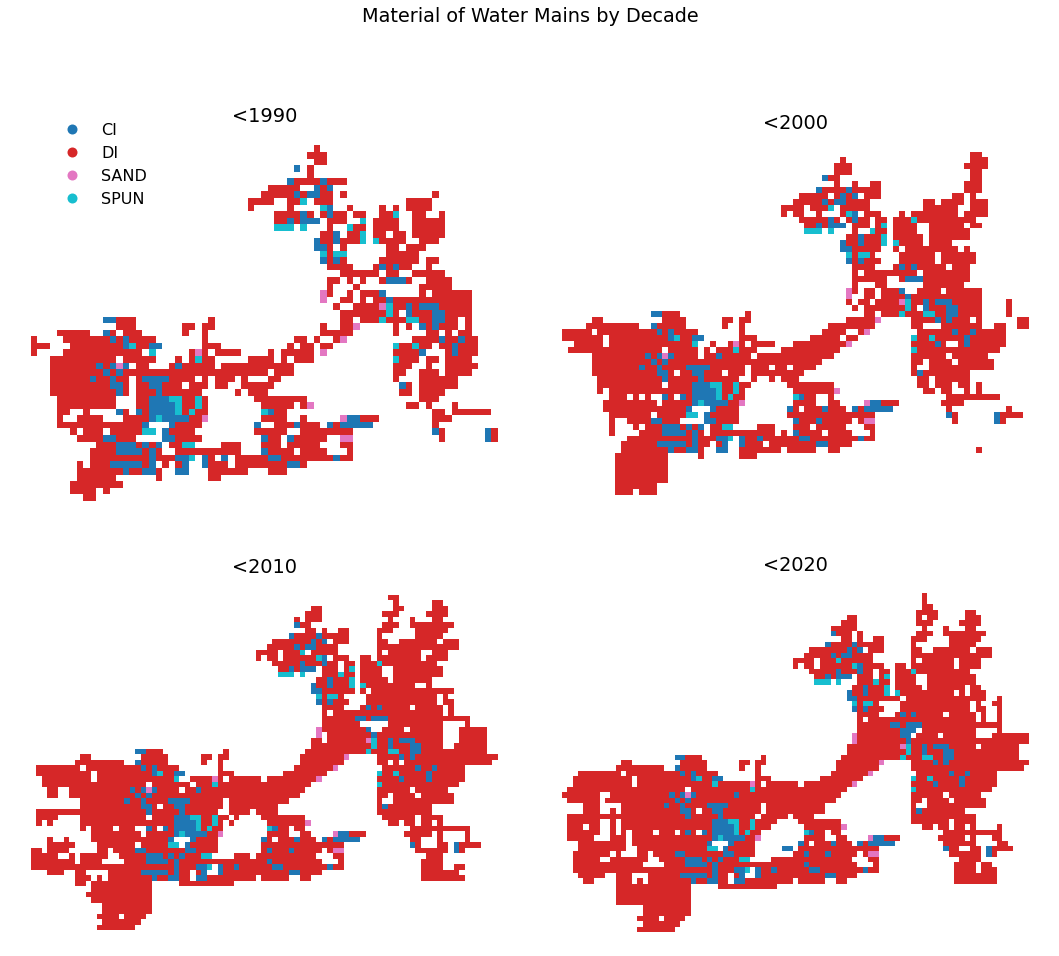

In [10]:
fig,axes = plt.subplots(2,2,figsize = (15,15))
axes = list(axes[0])+list(axes[1])
for yr in year_list:
    plot(axes.pop(0),yr)
plt.tight_layout()
fig.suptitle("Material of Water Mains by Decade")
plt.tight_layout()
#plt.savefig("Material by Decade.pdf")

In [11]:
roadPalette = {'DI': '#D3D3D3',
               'CI': 'brown',
               'SPUN': 'pink',
              'SAND':'blue',
              }
roadPalette

{'DI': '#D3D3D3', 'CI': 'brown', 'SPUN': 'pink', 'SAND': 'blue'}

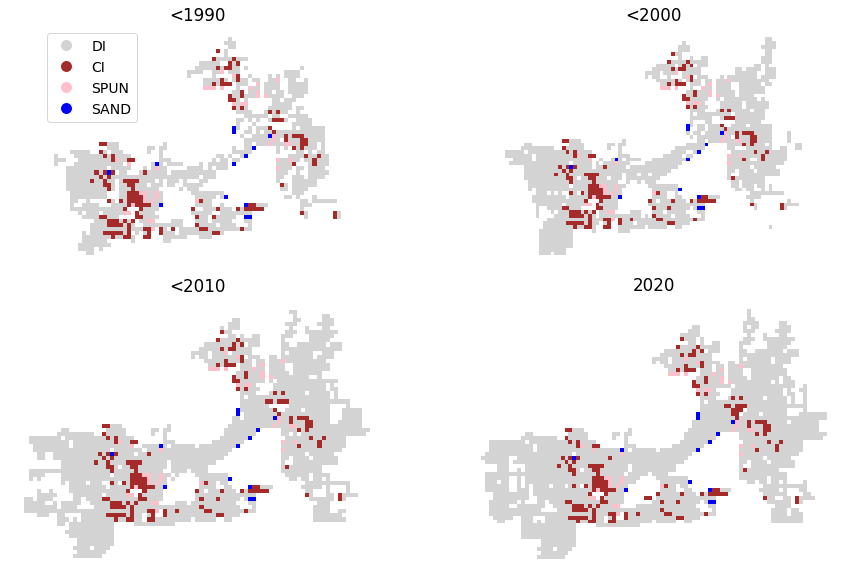

In [12]:
matplotlib.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(321)
bx = fig.add_subplot(322)
cx = fig.add_subplot(121)
dx = fig.add_subplot(122)

# Loop through each attribute type and plot it using the colors assigned in the dictionary
for ctype, data in df.groupby('Material'):
    
    # Define the color for each group using the dictionary
    color = roadPalette[ctype]
    data[data["InstallYea"]<1990].plot(color=color,ax=ax,label=ctype)
    data[data["InstallYea"]<2000].plot(color=color,ax=bx)
    data[data["InstallYea"]<2010].plot(color=color,ax=cx)
    data.plot(color=color,ax=dx)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='DI',
                          markerfacecolor='#D3D3D3', markersize=12),
                   Line2D([0], [0], marker='o', color='w', label='CI',
                          markerfacecolor='brown', markersize=12),
                   Line2D([0], [0], marker='o', color='w', label='SPUN',
                          markerfacecolor='pink', markersize=12),
                  Line2D([0], [0], marker='o', color='w', label='SAND',
                          markerfacecolor='blue', markersize=12)]    

ax.legend(handles=legend_elements,loc=2)

ax.axis("off")
ax.set_title("<1990")
bx.axis("off")
bx.set_title("<2000")
cx.axis("off")
cx.set_title("<2010")
dx.axis("off")
dx.set_title("2020")

plt.savefig("Material_by_Decade.png")
fig.show()

In [13]:
district = geopandas.read_file("../dataset/Neighborhood_Associations.zip")

In [14]:
wm=wm.to_crs("EPSG:4326")

In [15]:
neighbor = geopandas.sjoin(wm, district, how="inner", op='intersects')

In [16]:
neighbor= neighbor[neighbor["Material"]!="HDPE"]
neighbor= neighbor[neighbor["Material"]!="PVC"]
neighbor= neighbor[neighbor["Material"]!=None]
neighbor= neighbor[neighbor["Material"]!="COPPER"]
neighbor= neighbor[neighbor["Material"]!="CIPP"]
neighbor= neighbor[neighbor["Material"]!="DI"]
neighbor["Material"].unique()

array(['CI', 'SAND', None, 'SPUN'], dtype=object)

In [17]:
neighbor["NEIGHB_NAM"].value_counts()

Regent Neighborhood Association                               331
Midvale Heights Community Association                         306
Schenk-Atwood-Starkweather-Yahara Neighborhood Association    304
Capitol Neighborhoods                                         266
Schenk-Atwood Revitalization Association                      245
                                                             ... 
Majestic Oaks Neighborhood Association                          2
Stonefield Woods-Ridge Neighborhood Association                 2
Trinity Park Neighborhood Association                           1
Brittingham Apartments Resident's Association                   1
Whitetail Ridge                                                 1
Name: NEIGHB_NAM, Length: 92, dtype: int64